In [108]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [109]:
df = pd.read_csv("2007-2017.csv")
df.shape

(341170, 9)

In [110]:
from sklearn.utils import resample

df_majority = df[df['enquiry status'] == 'Rejected']
df_minority = df[df['enquiry status'] == 'Accepted']


# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=84136,    # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled['enquiry status'].value_counts()

Accepted    84136
Rejected    84136
Name: enquiry status, dtype: int64

In [111]:
# Separate majority and minority classes
df_majority = df[df['enquiry status'] == 'Rejected']
df_minority = df[df['enquiry status'] == 'Accepted']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=218370,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['enquiry status'].value_counts()

Rejected    257021
Accepted    218370
Name: enquiry status, dtype: int64

In [112]:
df = df_downsampled

In [113]:
target = 'enquiry status';

X = df[df.keys()]
X = df.loc[:,df.columns != target]
y = df[target]

In [114]:
category_column = X.select_dtypes(include='object')

In [115]:
from sklearn import preprocessing

transform_dict = {}
for col in category_column.columns:
    le = preprocessing.LabelEncoder()
    X[col] = le.fit_transform(X[col])
    transform_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [116]:
from sklearn.preprocessing import StandardScaler

feat_labels = X.columns[0:]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [117]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model
# from sklearn.ensemble import RandomForestClassifier

# # Create logistic regression
# randomForest = RandomForestClassifier()

# # Create range of candidate penalty hyperparameter values
# n_estimators = [100, 500, 1000]
# max_features = [3, 5, 8]

# # Create dictionary hyperparameter candidates
# hyperparameters = dict(n_estimators=n_estimators, max_features=max_features)

# # Create grid search
# gridsearch = GridSearchCV(randomForest, hyperparameters, cv=5, verbose=0 , n_jobs=-1)

# # Fit grid search
# best_model = gridsearch.fit(X, y)

In [118]:
# # View best hyperparameters
# print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
# print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])

In [119]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.4,
                     random_state=0,
                     stratify=y)

In [120]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1)
randomForest.fit(X_train, y_train)
rf_label = randomForest.predict(X_test)
print('Test Accuracy: %.3f' % randomForest.score(X_test, y_test))

Test Accuracy: 0.738


In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation

scores = cross_validation.cross_val_score(randomForest, X, y, cv=5)
print("Random forest cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print("Random forest")
print(classification_report(y_test, rf_label))

Random forest cross_validation: 0.66
Random forest
             precision    recall  f1-score   support

          0       0.71      0.80      0.75     33655
          1       0.77      0.68      0.72     33654

avg / total       0.74      0.74      0.74     67309



In [ ]:
prob_y_2 = randomForest.predict_proba(X)
prob_y_2 = [p[1] for p in prob_y_2]
print( roc_auc_score(y, prob_y_2) )

0.965083086022


[learning_curve] Training set sizes: [ 9086 18173 27259 36346 45432 54519 63605 72692 81778 90865]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.6min finished


train_mean [ 0.99996698  0.99984593  0.99981657  0.99977164  0.99973147  0.99968451
  0.99966355  0.99961756  0.99950353  0.99946294]
test_mean [ 0.70233634  0.70901204  0.71370686  0.71642073  0.72095702  0.72287851
  0.72545371  0.72805865  0.72956413  0.73375385]


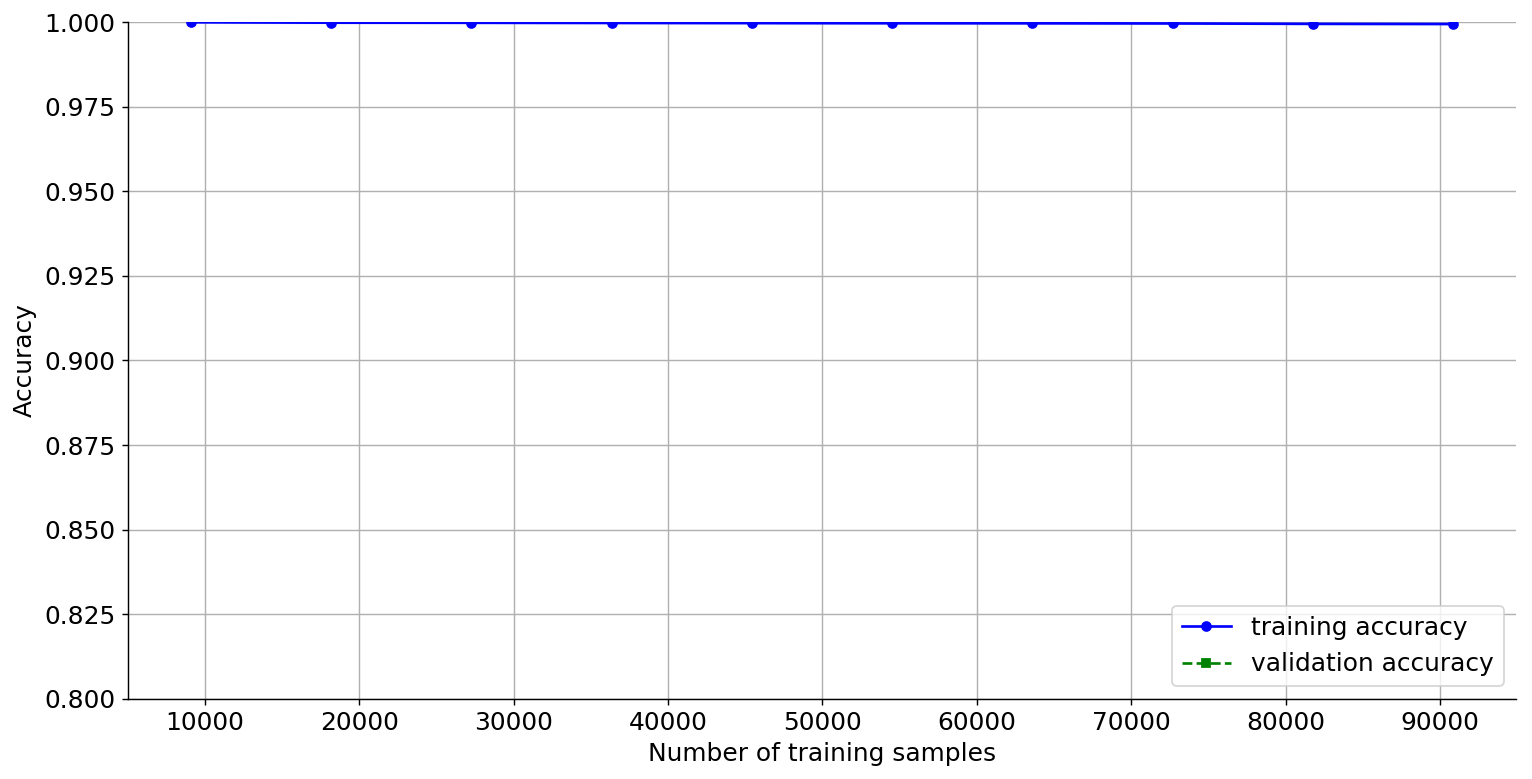

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=randomForest,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=-1,verbose=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print("train_mean",train_mean)
print("test_mean",test_mean)

In [ ]:
plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
# feat_labels = X.columns[0:]
importances = randomForest.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))

 1) loan amount                    0.358819
 2) day                            0.150163
 3) hour                           0.135002
 4) classification                 0.116053
 5) month                          0.097714
 6) weekday                        0.065399
 7) loan reason                    0.052916
 8) property use                   0.023933


In [ ]:
from sklearn.externals import joblib
encoder = joblib.load('app/models/encoder.pkl')

In [ ]:
import json
my_json_string = json.dumps({
#     'marketing_code':'P0001',
    "classification": "Direct",
    "enquired":"29/1/15 12:10",
    "loan amount": "1184000",
    "property_use": "Residence",
    "loan_reason": "Refinance"
})

In [ ]:
data = json.loads(my_json_string)
data = pd.DataFrame(data,index=[0])

In [ ]:
def transform_cols(df):
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace('_', ' ')
    return df

In [ ]:
transform_cols(data)

,classification,enquired,loan amount,loan reason,property use
0,Direct,29/1/15 12:10,1184000,Refinance,Residence


In [ ]:
data.dtypes

classification    object
enquired          object
loan amount       object
loan reason       object
property use      object
dtype: object

In [ ]:
def transform(df): 
    if 'loan amount' in df.columns: 
        df['loan amount'] = df['loan amount'].astype('float')
        
    if 'enquired' in df.columns: 
        df['enquired'] = pd.DatetimeIndex(df['enquired'])
        df['month'] = df['enquired'].dt.month
        df['day'] = df['enquired'].dt.day
        df['hour'] = df['enquired'].dt.hour
        df['weekday'] = df['enquired'].dt.dayofweek
    
    if 'post code' in df.columns: 
        df['post code'] = df['post code'].astype('int')
    
    if 'enquired'in df.columns:
        df.drop(['enquired'], axis = 1, inplace = True)

    return df.replace(encoder)

In [ ]:
data = transform(data)
data.dtypes

classification      int64
loan amount       float64
loan reason         int64
property use        int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [ ]:
data

,classification,loan amount,loan reason,property use,month,day,hour,weekday
0,7,1184000.0,4,2,1,29,12,3


In [ ]:
randomForest.predict(data)

array([0])

In [ ]:
print("posibility is: {}".format(np.max(randomForest.predict_proba(data))))

posibility is: 0.616


In [ ]:
df = pd.read_csv("2009-2017_origin.csv")

In [ ]:
df['classification'].value_counts()

Domain                         47775
Google AdWords                 26835
Direct                         25516
Coregistration                 21864
REA                            19767
Alternative Media              19131
Affiliate                      17338
None                           14050
Omnilead                       12845
Home Sales                      8089
All Homes                       7678
Partners                        5800
First Home Buyers               5516
Domain Campaigns                5171
Phone                           4731
Email eChoice Database          4357
Finder                          3971
Domain Internal CBA Program     3620
Domain Campaigns CPA            1975
Domain Competitions             1791
External Email                  1275
Folio                           1173
Dynamic Home Loans              1093
Retention                        901
Refinancing AdWords              893
Portals                          775
Portal Campaigns                 735
M

In [ ]:
test = df[df['enquiry status'] == 'Accepted']
# test = test[test['classification'] == 'Domain']
test = test.loc[:,test.columns != 'enquiry status']

In [ ]:
test = transform(test)

In [ ]:
# test

In [ ]:
prediction = randomForest.predict(test)

In [ ]:
proba = []
result = randomForest.predict_proba(test)
for row in range(len(result)):
    proba.append(np.max(result[row]))

In [ ]:
test["prediction"] = prediction
test["proba"] = proba

In [ ]:
test.sort_values(by=['proba'],ascending=False)

,classification,loan amount,loan reason,property use,month,day,hour,weekday,prediction,proba
61463,35,237500.0,0,2,7,1,17,1,1,0.782
61436,17,372102.0,0,0,7,1,14,1,1,0.782
61460,45,665262.0,0,2,7,1,17,1,1,0.782
61465,17,467761.0,0,2,7,1,18,1,1,0.782
213928,7,376000.0,0,0,3,1,9,1,1,0.782
157760,9,434713.0,0,2,12,1,19,1,1,0.782
184122,27,600000.0,0,0,9,1,8,1,1,0.782
213931,30,524000.0,0,2,3,1,9,1,1,0.782
121764,22,215635.0,0,2,5,1,8,1,1,0.782
208894,27,629000.0,0,0,2,1,23,1,1,0.782


In [ ]:
test[test['proba'] < 0.56].count()

classification    15619
loan amount       15619
loan reason       15619
property use      15619
month             15619
day               15619
hour              15619
weekday           15619
prediction        15619
proba             15619
dtype: int64

In [ ]:
test[test["prediction"] == 1].count()

classification    24334
loan amount       24334
loan reason       24334
property use      24334
month             24334
day               24334
hour              24334
weekday           24334
prediction        24334
proba             24334
dtype: int64

In [ ]:
test[test["prediction"] == 0].count()

classification    26006
loan amount       26006
loan reason       26006
property use      26006
month             26006
day               26006
hour              26006
weekday           26006
prediction        26006
proba             26006
dtype: int64

In [ ]:
X_train.shape

(100963, 8)